In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned/Training/Pituitary/image1_80.png
/kaggle/input/cleaned/Training/Pituitary/image1_930.png
/kaggle/input/cleaned/Training/Pituitary/image1_369.png
/kaggle/input/cleaned/Training/Pituitary/image1_39.png
/kaggle/input/cleaned/Training/Pituitary/image1_717.png
/kaggle/input/cleaned/Training/Pituitary/image1_622.png
/kaggle/input/cleaned/Training/Pituitary/image1_343.png
/kaggle/input/cleaned/Training/Pituitary/image1_891.png
/kaggle/input/cleaned/Training/Pituitary/image1_734.png
/kaggle/input/cleaned/Training/Pituitary/image1_738.png
/kaggle/input/cleaned/Training/Pituitary/image1_149.png
/kaggle/input/cleaned/Training/Pituitary/image1_526.png
/kaggle/input/cleaned/Training/Pituitary/image1_404.png
/kaggle/input/cleaned/Training/Pituitary/image1_111.png
/kaggle/input/cleaned/Training/Pituitary/image1_47.png
/kaggle/input/cleaned/Training/Pituitary/image1_162.png
/kaggle/input/cleaned/Training/Pituitary/image1_745.png
/kaggle/input/cleaned/Training/Pituitary/image1_763

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import legacy
from skimage.feature import graycomatrix, graycoprops
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

2024-04-19 17:26:03.156649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 17:26:03.156763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 17:26:03.313111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/cleaned/Training/'
test_dir = '/kaggle/input/cleaned/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [5]:
sizes = [
    len([x for x in train_labels if x == 'Pituitary']),
    len([x for x in train_labels if x == 'Meningioma']),
    len([x for x in train_labels if x == 'Glioma'])
]
sizes

[744, 566, 1140]

# Visualizing class distribution

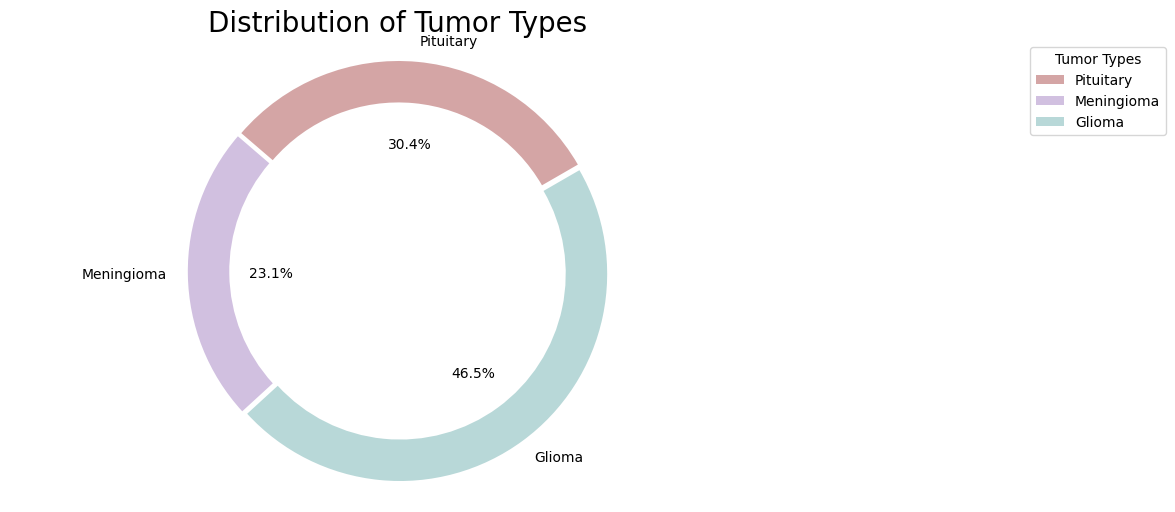

In [6]:
import matplotlib.pyplot as plt

# Data
labels = ['Pituitary',  'Meningioma', 'Glioma']
sizes = [
    len([x for x in train_labels if x == 'Pituitary']),
    len([x for x in train_labels if x == 'Meningioma']),
    len([x for x in train_labels if x == 'Glioma'])
]

# Custom color palette for a brain tumor vibe
colors = ['#D4A5A5', '#D1C0E0', '#B8D8D8']
explode = (0.015, 0.015, 0.015)

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Tumor Types', fontsize=20)

# Add a legend
plt.legend(labels, title='Tumor Types', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

# Distribution of Data between Train and Test Sets

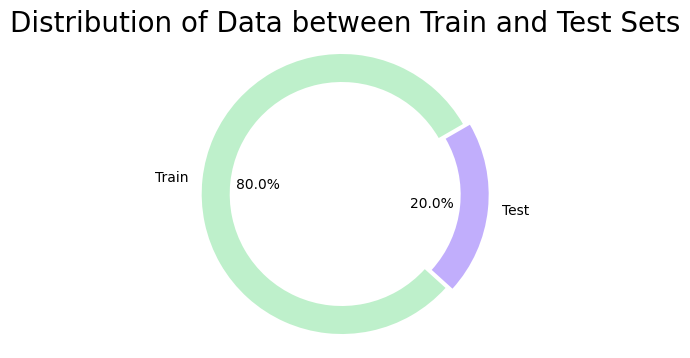

In [7]:
import matplotlib.pyplot as plt

# Data
labels = ['Train', 'Test']
sizes = [len(train_labels), len(test_labels)]
colors = ['#BEF0CB', '#C1AEFC']
explode = (0.05, 0)

# Plotting
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Data between Train and Test Sets', fontsize=20)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()


(256, 256, 3)


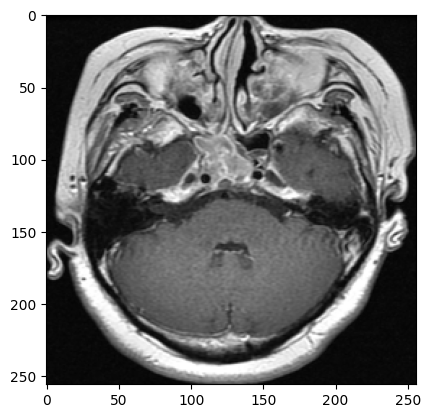

In [8]:
import cv2
image = cv2.imread(train_paths[0])
plt.imshow(image)
print(image.shape)


# Count of each class

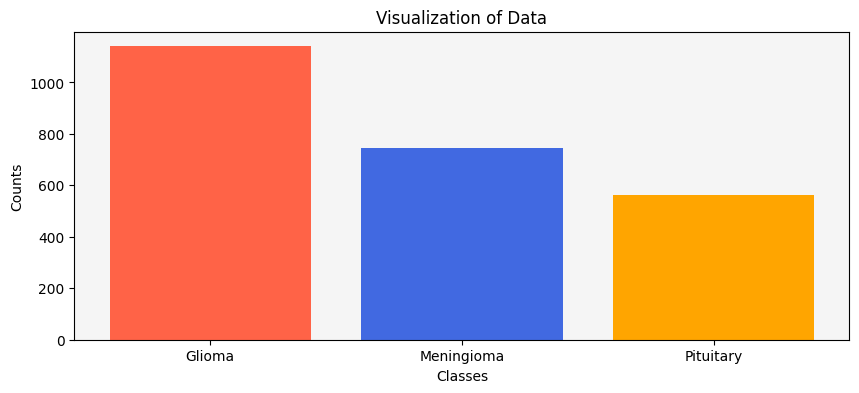

In [9]:
plt.figure(figsize=(10,4))
colors = ['#FF6347',  # Red for glioma
          '#4169E1',  # Blue for meningioma
          '#FFA500']  # Orange for pituitary
plt.bar(['Glioma','Meningioma','Pituitary'],[1140,744,564],color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data')
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [10]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    tr_df = shuffle(tr_df, random_state=42)
    return tr_df

In [11]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [12]:
tr_df = train_df('/kaggle/input/cleaned/Training')
ts_df = test_df('/kaggle/input/cleaned/Testing')

In [13]:
tr_df

,Class Path,Class
1290,/kaggle/input/cleaned/Training/Meningioma/imag...,Meningioma
986,/kaggle/input/cleaned/Training/Meningioma/imag...,Meningioma
2365,/kaggle/input/cleaned/Training/Glioma/image1_1...,Glioma
642,/kaggle/input/cleaned/Training/Pituitary/image...,Pituitary
607,/kaggle/input/cleaned/Training/Pituitary/image...,Pituitary
...,...,...
1638,/kaggle/input/cleaned/Training/Glioma/image1_1...,Glioma
1095,/kaggle/input/cleaned/Training/Meningioma/imag...,Meningioma
1130,/kaggle/input/cleaned/Training/Meningioma/imag...,Meningioma
1294,/kaggle/input/cleaned/Training/Meningioma/imag...,Meningioma


In [14]:
class_names = ['glioma', 'meningioma', 'pituitary']

# GLCM

In [15]:
def compute_glcm_features(image):
    distances = [1]  # You can experiment with different distances
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # You can experiment with different angles
    glcm = graycomatrix(image, distances=distances, angles=[0], levels=256,
                        symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    entropy = -np.sum(glcm * np.log(glcm + 1e-10))  # Compute entropy manually
    return np.concatenate((contrast, energy, homogeneity, correlation, [entropy]))

In [16]:
def load_and_compute_glcm_features(paths):
    features = []
    for path in paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        glcm_features = compute_glcm_features(image)
        features.append(glcm_features)
    return np.array(features)

In [17]:
X_features = load_and_compute_glcm_features(tr_df['Class Path'])

In [18]:
X_features.shape

(2450, 5)

In [20]:
columns = []
 # Each GLCM feature set consists of 5 features (contrast, energy, homogeneity, correlation, entropy)
columns.extend(["Contrast", "Energy", "Homogeneity", "Correlation", "Entropy"])

df_train = pd.DataFrame(X_features, columns=columns)

In [21]:
df_train

,Contrast,Energy,Homogeneity,Correlation,Entropy
0,149.865426,0.042538,0.283451,0.983137,8.145828
1,240.221569,0.064332,0.300208,0.973852,8.081332
2,135.191850,0.045357,0.292494,0.984034,7.872927
3,257.177543,0.034815,0.273827,0.953812,8.126478
4,327.960968,0.038571,0.218451,0.957456,8.434437
...,...,...,...,...,...
2445,194.165656,0.058482,0.343813,0.968321,7.369135
2446,70.712623,0.067284,0.374332,0.991069,7.676563
2447,323.319286,0.024257,0.199032,0.955090,8.737942
2448,238.451026,0.027224,0.249029,0.959051,8.465287


In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(tr_df['Class'])

# Model Creation

# XGBoost

In [27]:
import xgboost as xgb

# Step 3: Define a pipeline for preprocessing and training the model
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling (optional)
    ('classifier', xgb.XGBClassifier())  # XGBoost Classifier
])

# Step 4: Define hyperparameters to search over
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Step 5: Perform grid search cross-validation with k-fold cross-validation
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, n_jobs=-1)
grid_search_xgb.fit(df_train, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_xgb = grid_search_xgb.best_estimator_
mean_cv_accuracy_xgb = grid_search_xgb.best_score_
print("Best Model Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Mean Cross-Validation Accuracy (XGBoost):", mean_cv_accuracy_xgb)

Best Model Parameters (XGBoost): {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 50}
Mean Cross-Validation Accuracy (XGBoost): 0.7134693877551022


In [28]:
X_test_features = load_and_compute_glcm_features(test_paths)

# Test data predictions

In [30]:
y_pred = best_model_xgb.predict(X_test_features)

In [36]:
test_labels_encoded=label_encoder.transform(test_labels)

# Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       286
           1       0.57      0.37      0.45       142
           2       0.87      0.86      0.86       186

    accuracy                           0.73       614
   macro avg       0.71      0.68      0.69       614
weighted avg       0.72      0.73      0.72       614



<Figure size 800x600 with 0 Axes>

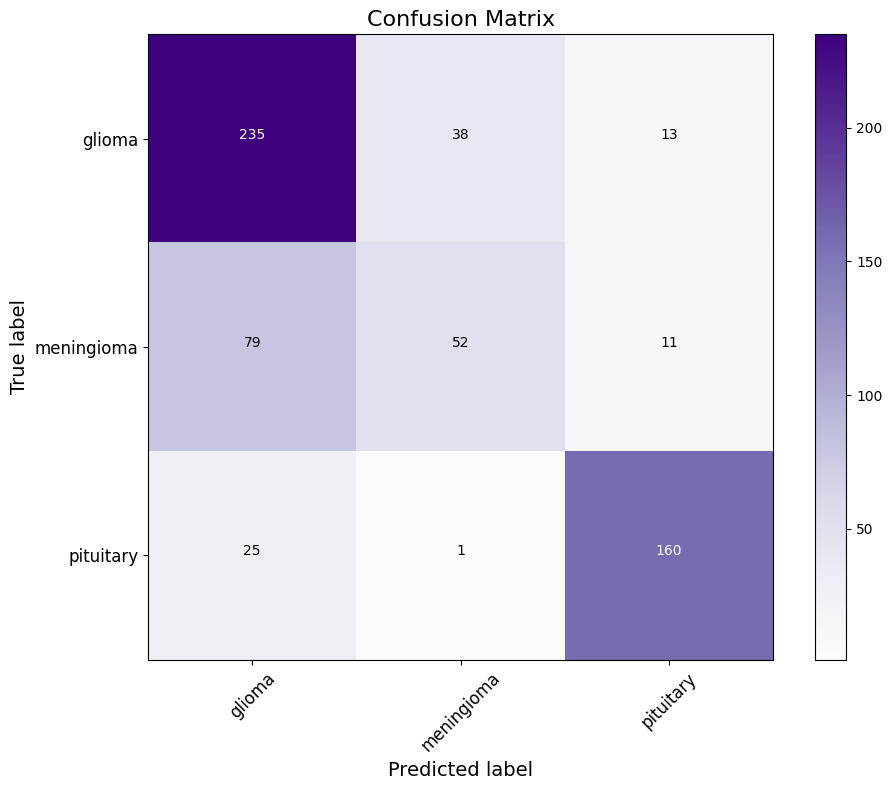

In [39]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()


# GNB

In [41]:
from sklearn.naive_bayes import GaussianNB

# Step 3: Define a pipeline for preprocessing and training the model
gnb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling (not necessarily required for GNB)
    ('classifier', GaussianNB())  # Gaussian Naive Bayes Classifier
])

# No hyperparameters to search over for GNB

# Step 5: Perform grid search cross-validation with k-fold cross-validation
grid_search_gnb = GridSearchCV(gnb_pipeline, {}, n_jobs=-1)
grid_search_gnb.fit(df_train, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_gnb = grid_search_gnb.best_estimator_
mean_cv_accuracy_gnb = grid_search_gnb.best_score_
print("Best Model Parameters (GNB):", grid_search_gnb.best_params_)
print("Mean Cross-Validation Accuracy (GNB):", mean_cv_accuracy_gnb)

Best Model Parameters (GNB): {}
Mean Cross-Validation Accuracy (GNB): 0.5787755102040817


In [43]:
y_pred_GNB = best_model_gnb.predict(X_test_features)

# Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred_GNB)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       286
           1       0.45      0.35      0.39       142
           2       0.67      0.82      0.73       186

    accuracy                           0.61       614
   macro avg       0.58      0.59      0.58       614
weighted avg       0.59      0.61      0.60       614



<Figure size 800x600 with 0 Axes>

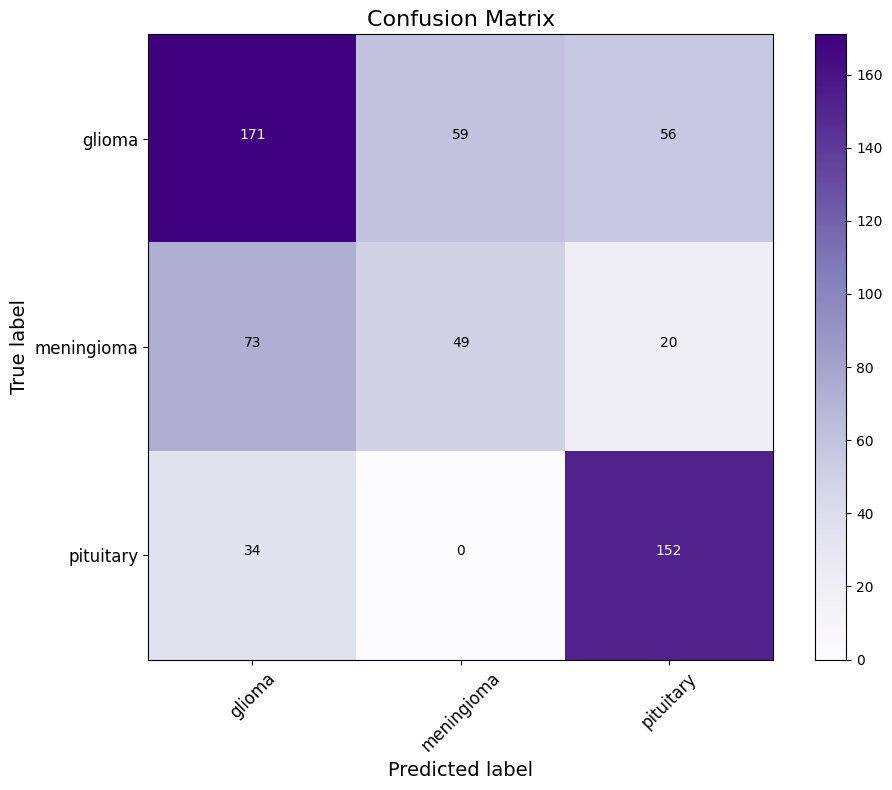

In [46]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred_GNB)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()


# SVM

In [49]:
from sklearn.svm import SVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', SVC())  # Support Vector Classifier
])

# Step 4: Define hyperparameters to search over
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

# Step 5: Perform grid search cross-validation with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=kf, n_jobs=-1)
grid_search_svm.fit(df_train, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_svm = grid_search_svm.best_estimator_
mean_cv_accuracy_svm = grid_search_svm.best_score_
print("Best Model Parameters (SVM):", grid_search_svm.best_params_)
print("Mean Cross-Validation Accuracy (SVM):", mean_cv_accuracy_svm)

Best Model Parameters (SVM): {'classifier__C': 10, 'classifier__gamma': 'scale'}
Mean Cross-Validation Accuracy (SVM): 0.7155102040816328


In [51]:
y_pred_SVM = best_model_gnb.predict(X_test_features)

# Confusion Matrix

In [52]:
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred_SVM)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       286
           1       0.45      0.35      0.39       142
           2       0.67      0.82      0.73       186

    accuracy                           0.61       614
   macro avg       0.58      0.59      0.58       614
weighted avg       0.59      0.61      0.60       614



<Figure size 800x600 with 0 Axes>

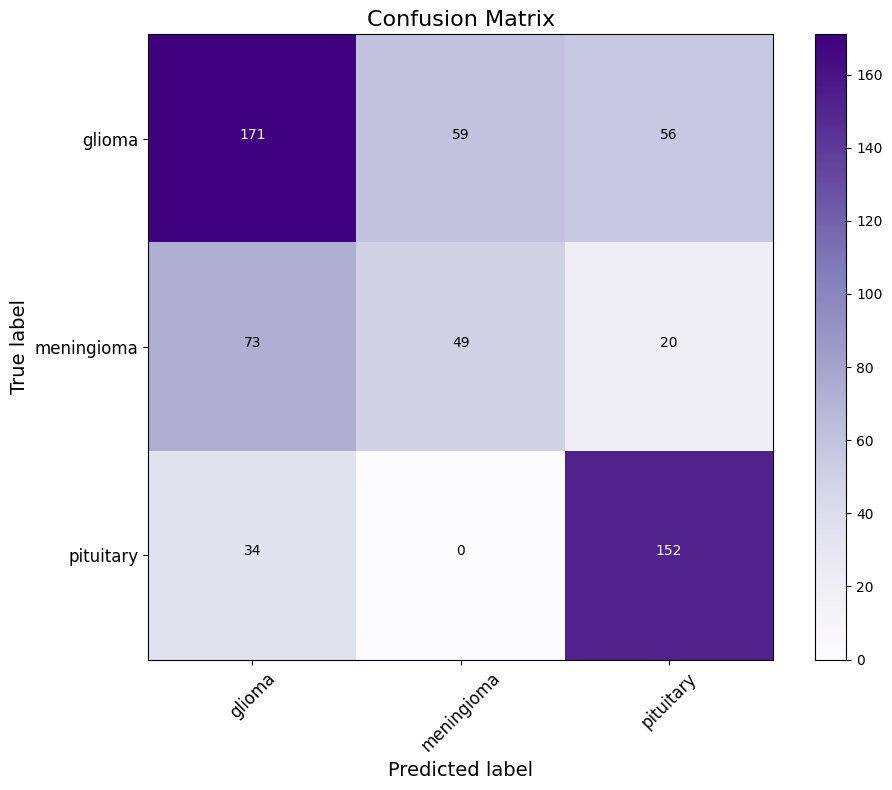

In [53]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred_SVM)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()
